# CHAPTER 3
CNN and RNN Using PyTorch

In [1]:
import torch
import sklearn
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1)

EPOCH = 10
BATCH_SIZE = 64
TIME_STEP = 28
INPUT_SIZE = 28
LEARNING_RATE = 0.01

## Recipe 3-8. Implementing a Recurrent Neural Network (RNN)
The recurrent neural network is considered as a memory net work. It takes a sequence of vectors in the input layer and produces a sequence of vectors in the output layer.

D:\Anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torch.Size([60000, 28, 28])
torch.Size([60000])


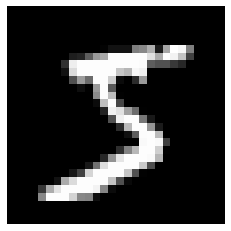

In [2]:
train_data = torchvision.datasets.MNIST(
    root='data/',
    train=True,
    transform=torchvision.transforms.ToTensor()
)

print(train_data.data.shape)
print(train_data.targets.shape)
plt.imshow(train_data.data[0], cmap='gray')
plt.axis('off')
plt.show()

In [3]:
train_loader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_data = torchvision.datasets.MNIST(
    root='data/',
    train=False,
    transform=torchvision.transforms.ToTensor()
)
test_x = Variable(test_data.data, volatile=True) \
        .type(torch.FloatTensor) / 255
test_y = test_data.targets

<ipython-input-3-a521a30af694>:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  test_x = Variable(test_data.data, volatile=True) \


Long Short-Time Memory (LSTM) network is effective for holding memory for a long time. If use `nn.RNN()`, it hardly learns the parameters, because the vanilla implementation of RNN cannot hold or remember the imformation for a long time.

The input size is the image width. Hidden size is the number of neurons in the hidden layer. Output size is (Hidden size, 10).

In [4]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        
        self.rnn = nn.LSTM(
            input_size = INPUT_SIZE,
            hidden_size = 64,
            num_layers = 1,
            batch_first = True      # I/O.shape = (BATCH_SIZE, TIME_STEP, IO_SIZE)
        )
        self.out = nn.Linear(64, 10)
        
    def forward(self, x):
        # x.shape = (BATCH_SIZE, TIME_STEP, INPUT_SIZE)
        # r_out.shape = (BATCH_SIZE, TIME_STEP, OUTPUT_SIZE)
        # h_n.shape = (n_layers, BATCH_SIZE, hidden_size)
        # h_c.shape = (n_layers, BATCH_SIZE, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)
        
        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

In [5]:
rnn = RNN()
print(rnn)
optimizer = torch.optim.Adam(rnn.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [6]:
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        # batch_x.shape = (BATCH_SIZE, INPUT_SIZE, INPUT_SIZE)
        batch_x = Variable(x.view(-1, 28, 28))
        # batch_x.shape = (BATCH_SIZE)
        batch_y = Variable(y)
        
        output = rnn(batch_x)
        loss = loss_fn(output, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch == 0 and  step % 100 == 0:
            test_output = rnn(test_x)
            test_y_pred = torch.max(test_output, dim=1).indices
            accuracy = (test_y_pred == test_y).sum()
            print('Epoch: {:2} | step: {:3} | train loss = {:.4f} | test accuracy = {:4} / {}'.
                  format(epoch, step, loss.data, accuracy, test_y.shape[0]))
    test_output = rnn(test_x)
    test_y_pred = torch.max(test_output, dim=1).indices
    accuracy = (test_y_pred == test_y).sum()
    print('Epoch: {:2} | train loss = {:.4f} | test accuracy = {:4} / {}'.
            format(epoch, loss.data, accuracy, test_y.shape[0]))

Epoch:  0 | step:   0 | train loss = 2.3088 | test accuracy =  960 / 10000
Epoch:  0 | step: 100 | train loss = 0.8970 | test accuracy = 7166 / 10000
Epoch:  0 | step: 200 | train loss = 0.3180 | test accuracy = 8451 / 10000
Epoch:  0 | step: 300 | train loss = 0.3900 | test accuracy = 9137 / 10000
Epoch:  0 | step: 400 | train loss = 0.1543 | test accuracy = 9374 / 10000
Epoch:  0 | step: 500 | train loss = 0.1907 | test accuracy = 9472 / 10000
Epoch:  0 | step: 600 | train loss = 0.1787 | test accuracy = 9437 / 10000
Epoch:  0 | step: 700 | train loss = 0.0734 | test accuracy = 9555 / 10000
Epoch:  0 | step: 800 | train loss = 0.0559 | test accuracy = 9680 / 10000
Epoch:  0 | step: 900 | train loss = 0.1129 | test accuracy = 9660 / 10000
Epoch:  0 | train loss = 0.0797 | test accuracy = 9571 / 10000
Epoch:  1 | train loss = 0.1031 | test accuracy = 9685 / 10000
Epoch:  2 | train loss = 0.1082 | test accuracy = 9778 / 10000
Epoch:  3 | train loss = 0.0062 | test accuracy = 9792 / 1000

In [7]:
test_output = rnn(test_x[:10])
test_y_pred = torch.max(test_output, dim=1).indices
print("predicted:", test_y_pred)
print("actually: ", test_y[:10])

predicted: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])
actually:  tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])
